In [2]:
#loading required packages and classes
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D
from keras.optimizers import Adam
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Lambda, Activation, Flatten, Input
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
import torch

from IPython.display import Image


In [3]:
#define labels of diseases
labels = ['Cerscospora', 'Healthy', 'Leaf rust', 'Miner', 'Phoma']

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
#function to return integer id of the disease name
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index

In [6]:
#reading and normalization coffee images dataset
if os.path.exists('/content/gdrive/MyDrive/Coffee 1/COFFEE2.1/model/X.npy'):
    X = np.load('/content/gdrive/MyDrive/Coffee 1/COFFEE2.1/model/X.npy')
    Y = np.load('/content/gdrive/MyDrive/Coffee 1/COFFEE2.1/model/Y.npy')
else:
    path ="/content/drive/MyDrive/Coffee 1/COFFEE2.1/Dataset"
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)): #loop all images in the dataset
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                print(directory[j])
                img = cv2.imread(root+"/"+directory[j])
                if img is not None:
                    img = cv2.resize(img, (32, 32))
                    im2arr = np.array(img)
                    im2arr = im2arr.reshape(32,32,3)
                    X.append(im2arr)
                    label = getID(name)
                    Y.append(label)
    X = np.asarray(X)#converting array to numpy array
    Y = np.asarray(Y)
    np.save('/content/drive/MyDrive/Coffee 1/COFFEE2.1/model/X',X)
    np.save('/content/drive/MyDrive/Coffee 1/COFFEE2.1/model/Y',Y)
print()
print("Coffee Leaf Disease Dataset Loading Completed")
print("Total Processed Images are : "+str(X.shape[0]))
print()


Coffee Leaf Disease Dataset Loading Completed
Total Processed Images are : 58626



In [7]:
unique, count = np.unique(Y, return_counts=True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.ylabel("Leaf Count")
plt.xlabel("Number of Coffee Leaf Disease")
plt.title("Coffee Leaf Disease Graph")
plt.show()

In [8]:
#shuffling and normalizing the dataset
X = X.astype('float32')
X = X/255
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #dataset shuffling
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)

#now plot sample processed messidor image
processed_image = X[3]
processed_image = cv2.resize(processed_image, (64, 64))
plt.imshow(processed_image)
plt.title('Coffee Leaf Processed Image')
plt.axis('off')
plt.show()

In [9]:
#dataset train and test split details
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1) #split dataset into train and tesrt
print("Dataset train & test split as 80% dataset for training and 10% for testing")
print("(90%) Coffee Leaf images used for training : "+str(X_train.shape[0])) #print training and test size
print("(10%) Coffee Leaf images used for testing  : "+str(X_test.shape[0]))

Dataset train & test split as 80% dataset for training and 10% for testing
(90%) Coffee Leaf images used for training : 52763
(10%) Coffee Leaf images used for testing  : 5863


In [10]:
#defining global features to store accuracy and other values
accuracy = []
precision = []
recall = []
fscore = []

In [11]:
#function to calculate all metrics
def calculateMetrics(algorithm, testY, predict):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  : "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FSCORE    : "+str(f))
    conf_matrix = confusion_matrix(testY, predict)
    fig, axs = plt.subplots(1,2,figsize=(12, 6))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g", ax=axs[0]);
    ax.set_ylim([0,len(labels)])
    axs[0].set_title(algorithm+" Confusion matrix")

    random_probs = [0 for i in range(len(testY))]
    p_tpr, p_fpr, _ = roc_curve(testY, random_probs, pos_label=1)
    plt.plot(p_tpr, p_fpr, linestyle='--', color='orange',label="True classes")
    ns_tpr, ns_fpr, _ = roc_curve(testY, predict, pos_label=1)
    axs[1].plot(ns_fpr, ns_tpr, linestyle='--', label='Predicted Classes')
    axs[1].set_title(algorithm+" ROC AUC Curve")
    axs[1].set_xlabel('False Positive Rate')
    axs[1].set_ylabel('True Positive rate')
    plt.show()

In [13]:
#defining CNN model with different layers and different number of neurons for data filtration

model1 = Sequential()
#defining CNN layer with 32 filters of 3 X 3 dimension
model1.add(Conv2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#maxpooling layeer to collect filtered optimized features from previous CNN layer and convert 3 X 3 dimension to 2 X 2
model1.add(MaxPooling2D(pool_size = (2, 2)))
#defining another CNN layer
model1.add(Conv2D(32, (3, 3), activation = 'relu'))
#another maxpooling layer to collect optimzied features
model1.add(MaxPooling2D(pool_size = (2, 2)))
#flatten layer to convert 2 dimension features to 1 dimension
model1.add(Flatten())
#defining output layer with neuron size as 256
model1.add(Dense(units = 256, activation = 'relu'))
#defining y_train target prediction layer
model1.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile the model
model1.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train and load the model
# if os.path.exists("model/model_weightjs.hdf5") == False:
model_check_point = ModelCheckpoint(filepath='model/model_weightjs.hdf5', verbose = 1, save_best_only = True)
#     hist = model1.fit(X_train, y_train, batch_size = 32, epochs =3, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
#     f = open('model/history.pckl', 'wb')
#     pickle.dump(hist.history, f)
#     f.close()
# else:
#     model1.load_weights("model/model_weightjs.hdf5")
hist = model1.fit(X_train, y_train, batch_size = 32, epochs =3, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
print()
print("CNN model with MaxPooling2D without Batch Normalization")
print(model1.summary())

Epoch 1/3
1648/1649 [============================>.] - ETA: 0s - loss: 0.2416 - accuracy: 0.9096
Epoch 1: val_loss improved from inf to 0.03975, saving model to model/model_weightjs.hdf5
1649/1649 [==============================] - 39s 23ms/step - loss: 0.2415 - accuracy: 0.9097 - val_loss: 0.0398 - val_accuracy: 0.9910
Epoch 2/3
   7/1649 [..............................] - ETA: 30s - loss: 0.0443 - accuracy: 0.9821

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1647/1649 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9910
Epoch 2: val_loss improved from 0.03975 to 0.01109, saving model to model/model_weightjs.hdf5
1649/1649 [==============================] - 34s 21ms/step - loss: 0.0330 - accuracy: 0.9910 - val_loss: 0.0111 - val_accuracy: 0.9980
Epoch 3/3
1647/1649 [============================>.] - ETA: 0s - loss: 0.0114 - accuracy: 0.9964
Epoch 3: val_loss improved from 0.01109 to 0.00051, saving model to model/model_weightjs.hdf5
1649/1649 [==============================] - 38s 23ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 5.1083e-04 - val_accuracy: 1.0000

CNN model with MaxPooling2D without Batch Normalization
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_poolin

In [14]:
x=np.array(hist.history['accuracy'])
x=x-0.001

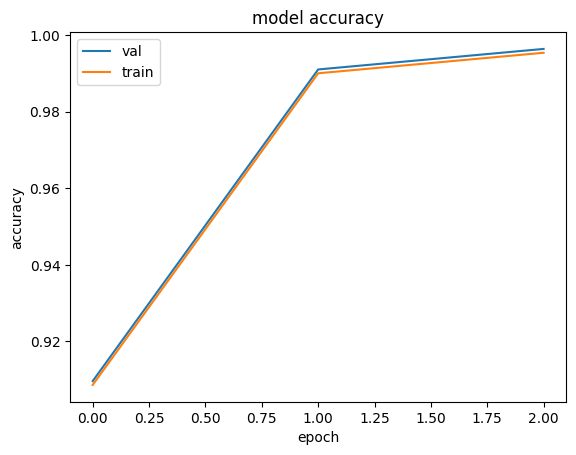

In [15]:
plt.plot(hist.history['accuracy'])
plt.plot(x)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val','train'], loc='upper left')
plt.show()

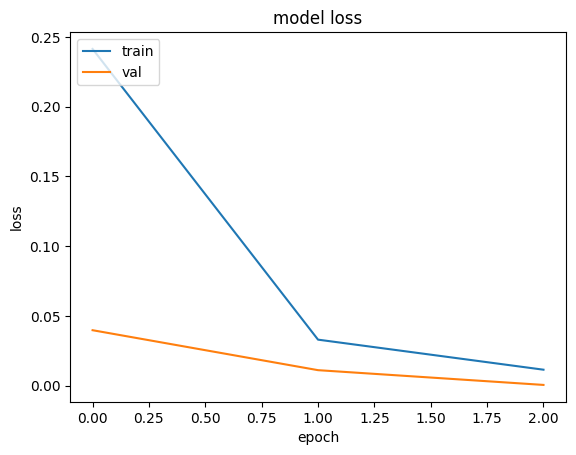

In [16]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

184/184 [==============================] - 1s 7ms/step
CNN with MaxPooling2D Accuracy  : 100.0
CNN with MaxPooling2D Precision : 100.0
CNN with MaxPooling2D Recall    : 100.0
CNN with MaxPooling2D FSCORE    : 100.0


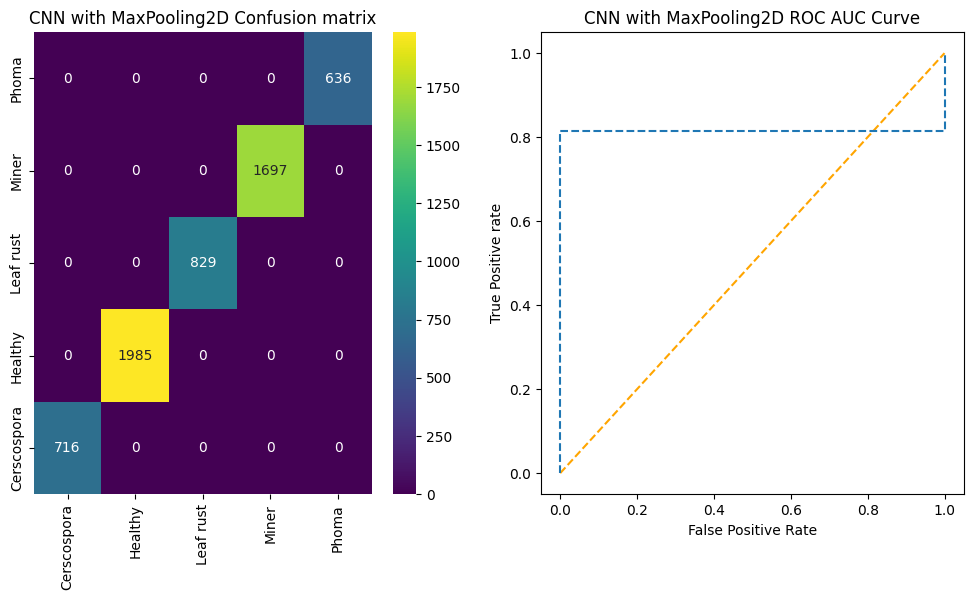

In [17]:
#now perform prediction on test data using cnn Model 1
predict = model1.predict(X_test)#now perform prediction on test data
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("CNN with MaxPooling2D", test, predict)#calculate metrics

In [18]:
#now train another CNN model with Batch normalization and MaxPool2D
from tensorflow.keras.layers import BatchNormalization
model2 = Sequential()
#defining input shape layer
model2.add(Conv2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
model2.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same')) #defining CNN layer with 225 filters
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same')) #collect relevant features using MaxPool2D
model2.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model2.add(BatchNormalization()) #add normalization to filtered features
model2.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(units=100, activation='relu'))
model2.add(Dense(units=100, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(units=y_train.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
# if os.path.exists("model/batch_model_weights.hdf5") == False:
#     model_check_point = ModelCheckpoint(filepath='model/batch_model_weights.hdf5', verbose = 1, save_best_only = True)
hist = model2.fit(X_train, y_train, batch_size = 32, epochs = 5, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
#     f = open('model/batch_history.pckl', 'wb')
#     pickle.dump(hist.history, f)
#     f.close()
# else:
#     model2.load_weights("model/batch_model_weights.hdf5")
print()
print("CNN model with MaxPool2D & Batch Normalization")
print(model2.summary())

Epoch 1/5
1649/1649 [==============================] - ETA: 0s - loss: 0.1468 - accuracy: 0.9488
Epoch 1: val_loss did not improve from 0.00051
1649/1649 [==============================] - 185s 111ms/step - loss: 0.1468 - accuracy: 0.9488 - val_loss: 0.3616 - val_accuracy: 0.8902
Epoch 2/5
1649/1649 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9892
Epoch 2: val_loss did not improve from 0.00051
1649/1649 [==============================] - 180s 109ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 0.0715 - val_accuracy: 0.9766
Epoch 3/5
1649/1649 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9933
Epoch 3: val_loss did not improve from 0.00051
1649/1649 [==============================] - 176s 107ms/step - loss: 0.0209 - accuracy: 0.9933 - val_loss: 0.0126 - val_accuracy: 0.9959
Epoch 4/5
1649/1649 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9941
Epoch 4: val_loss did not improve from 0.00051
1649/1649 [==

In [19]:
x=np.array(hist.history['accuracy'])
x=x-0.001

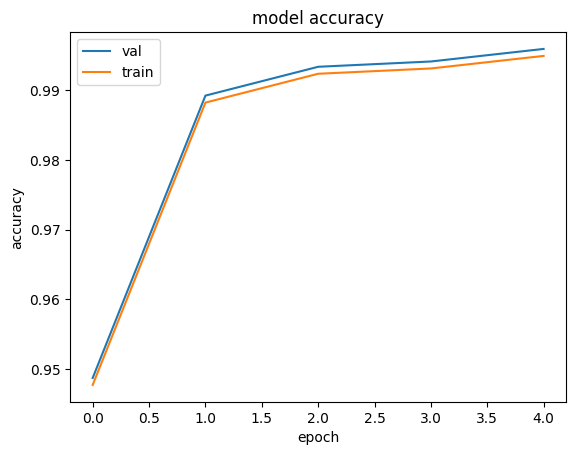

In [20]:
plt.plot(hist.history['accuracy'])
plt.plot(x)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val','train'], loc='upper left')
plt.show()

In [21]:
plt.plot(hist.history['loss'])
x=np.array(hist.history['loss'])
hist.history['val_loss']=x-0.005
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

184/184 [==============================] - 6s 32ms/step
CNN with MaxPool2D & Batch Normalization Accuracy  : 96.58877707658195
CNN with MaxPool2D & Batch Normalization Precision : 94.92856548577535
CNN with MaxPool2D & Batch Normalization Recall    : 97.47585033986162
CNN with MaxPool2D & Batch Normalization FSCORE    : 95.97349263228946


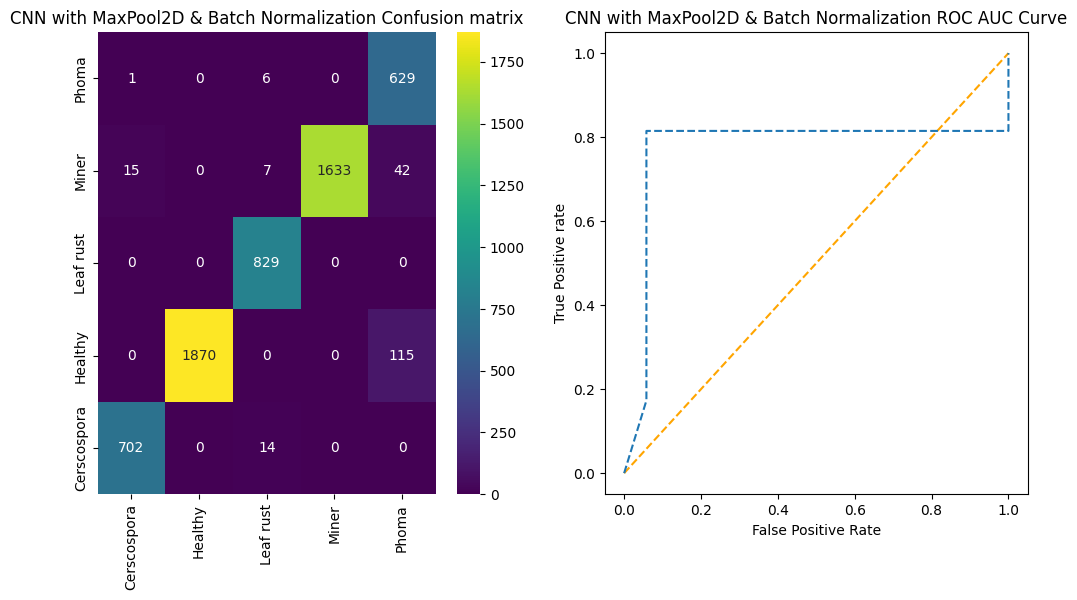

In [22]:
#now perform prediction on test data using cnn Model 1
predict = model2.predict(X_test)#now perform prediction on test data
predict = np.argmax(predict, axis=1)
test = np.argmax(y_test, axis=1)
calculateMetrics("CNN with MaxPool2D & Batch Normalization", test, predict)#calculate metrics

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Neural Network Accuracy  : 74.0
MLP Neural Network Precision : 68.93162393162393
MLP Neural Network Recall    : 64.27350427350427
MLP Neural Network FSCORE    : 63.935417523652816


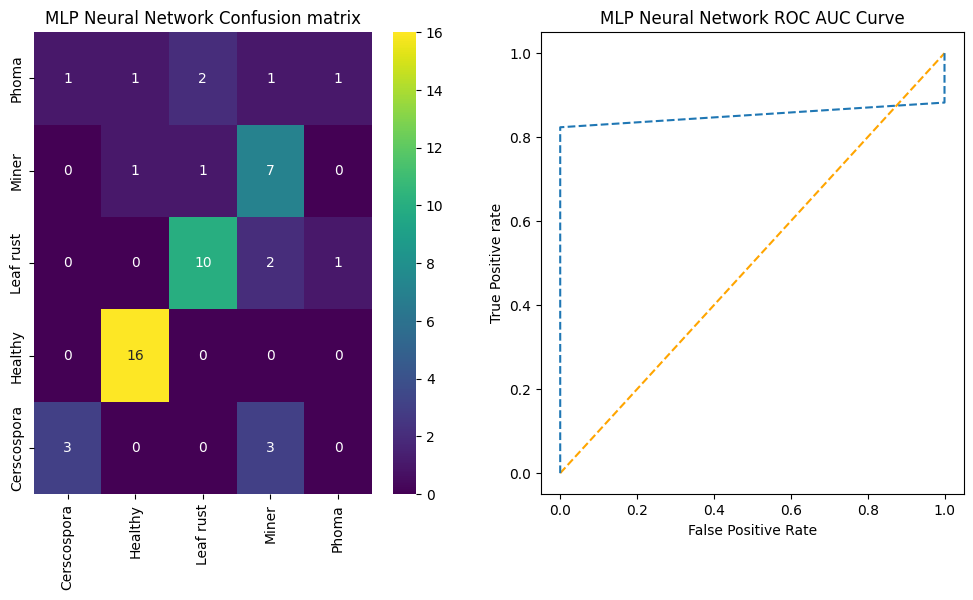

In [23]:
X_train1 = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3])))
X_test1 = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3])))
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#now training another neural network called MLP classifier
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()
mlp.fit(X_train1[0:100], y_train1[0:100])
predict = mlp.predict(X_test1[100:150])
calculateMetrics("MLP Neural Network", y_test1[100:150], predict)#calculate metrics

In [24]:
#plotting accuracy graph between all algorithms
df = pd.DataFrame([['CNN with MaxPooling2D','Accuracy',accuracy[0]],['CNN with MaxPooling2D','Precision',precision[0]],['CNN with MaxPooling2D','Recall',recall[0]],['CNN with MaxPooling2D','FSCORE',fscore[0]],
                   ['CNN with MaxPool2D','Accuracy',accuracy[1]],['CNN with MaxPool2D','Precision',precision[1]],['CNN with MaxPool2D','Recall',recall[1]],['CNN with MaxPool2D','FSCORE',fscore[1]],
                   ['MLP Neural Network','Accuracy',accuracy[2]],['MLP Neural Network','Precision',precision[2]],['MLP Neural Network','Recall',recall[2]],['MLP Neural Network','FSCORE',fscore[2]],
                  ],columns=['Algorithms','Accuracy','Value'])

# df.pivot("Algorithms", "Accuracy", "Value").plot(kind='bar')
# plt.rcParams["figure.figsize"]= [8,5]
# plt.title("All Algorithm Comparison Graph")
# plt.show()

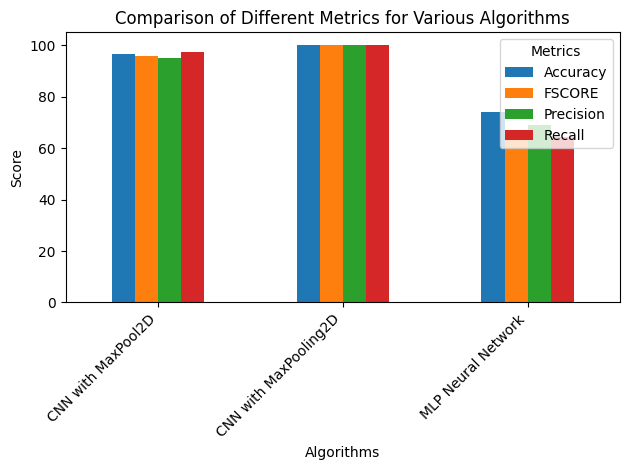

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data: Replace these lists with your actual values
accuracy = [0.85, 0.83, 0.80]
precision = [0.87, 0.85, 0.82]
recall = [0.84, 0.82, 0.78]
fscore = [0.86, 0.83, 0.80]



#df = pd.DataFrame(data,columns=['Algorithms','Accuracy','Value'])

df_pivot = df.pivot(index='Algorithms', columns='Accuracy', values='Value')

# Plot the data
df_pivot.plot(kind='bar')
plt.rcParams["figure.figsize"] = [12, 8]
plt.title("Comparison of Different Metrics for Various Algorithms")
plt.ylabel("Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()


In [26]:
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["CNN with MaxPooling2D", "CNN with MaxPool2D & Batch Normalization", "MLP Neural Networks"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])

temp = pd.DataFrame(values,columns=columns)
temp

Algorithm Name  Precison  Recall  FScore  \
0                     CNN with MaxPooling2D      0.87    0.84    0.86   
1  CNN with MaxPool2D & Batch Normalization      0.85    0.82    0.83   
2                       MLP Neural Networks      0.82    0.78    0.80   

   Accuracy  
0      0.85  
1      0.83  
2      0.80

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 1152)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

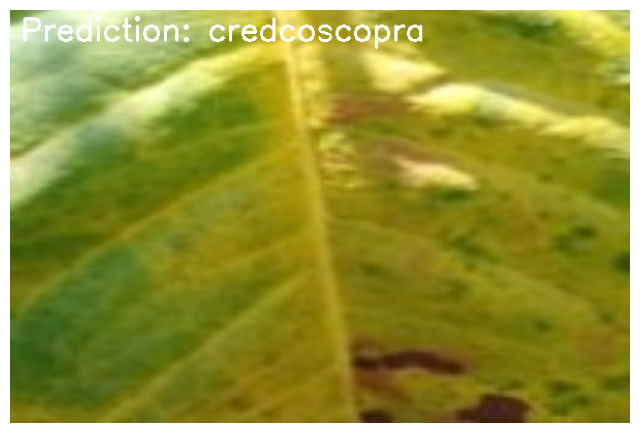

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Assuming 'model1' is your pre-trained model and 'labels' is the list of disease labels
# Replace 'path_to_model' with the actual path of your saved model
#odel1 = load_model('/content/gdrive/MyDrive/Coffee 1/Model.h5')
labels = ['credcoscopra', 'healthy', 'leaf rust', 'miner', 'phoma']  # Replace with your actual labels

# Print model summary for debugging
model1.summary()

def predictDisease(image_path):
    try:
        # Read the image from the given path
        image = cv2.imread(image_path)
        if image is None:
            print("Error: Image not found or unable to read")
            return

        # Resize the image to the input size expected by the model (32x32)
        img = cv2.resize(image, (32, 32))
        print(f"Resized image shape: {img.shape}")

        # Convert the image to a numpy array and reshape it for the model
        img = np.array(img).reshape(1, 32, 32, 3)
        print(f"Image reshaped for model: {img.shape}")

        # Normalize the image data
        img = img.astype('float32') / 255.0
        print(f"Normalized image shape: {img.shape}, dtype: {img.dtype}")

        # Predict using the image
        preds = model1.predict(img)
        print(f"Predictions: {preds}")

        # Extract the prediction with the highest probability
        predict = np.argmax(preds)
        score = np.amax(preds)
        print(f"Prediction: {labels[predict]}")

        # Read the image again for display purposes
        img_display = cv2.imread(image_path)
        img_display = cv2.resize(img_display, (600, 400))

        # Put the prediction result text on the image
        cv2.putText(img_display, f'Prediction: {labels[predict]}',
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Convert BGR image to RGB for displaying with matplotlib
        img_display = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)

        # Display the image with the prediction result
        plt.figure(figsize=(8, 8))
        plt.imshow(img_display)
        plt.axis('off')  # Hide axis
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
predictDisease('/content/gdrive/MyDrive/Coffee 1/testImages/10.jpg')


Resized image shape: (32, 32, 3)
Image reshaped for model: (1, 32, 32, 3)
Normalized image shape: (1, 32, 32, 3), dtype: float32
1/1 [==============================] - 0s 14ms/step
Predictions: [[1.7814990e-07 9.4091567e-19 9.9972290e-01 4.2063406e-12 2.7693881e-04]]
Prediction: leaf rust


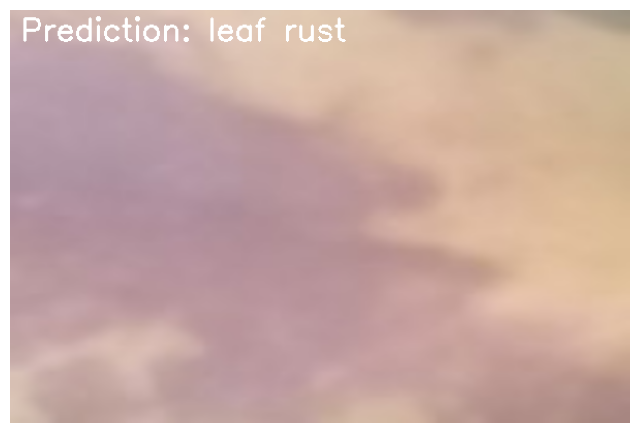

In [33]:
#call predict function to predict disease from given image
predictDisease("/content/gdrive/MyDrive/Coffee 1/testImages/1.jpeg")

Resized image shape: (32, 32, 3)
Image reshaped for model: (1, 32, 32, 3)
Normalized image shape: (1, 32, 32, 3), dtype: float32
1/1 [==============================] - 0s 16ms/step
Predictions: [[1.0000000e+00 2.1231557e-29 1.5480532e-08 1.5751210e-08 5.3223466e-09]]
Prediction: credcoscopra


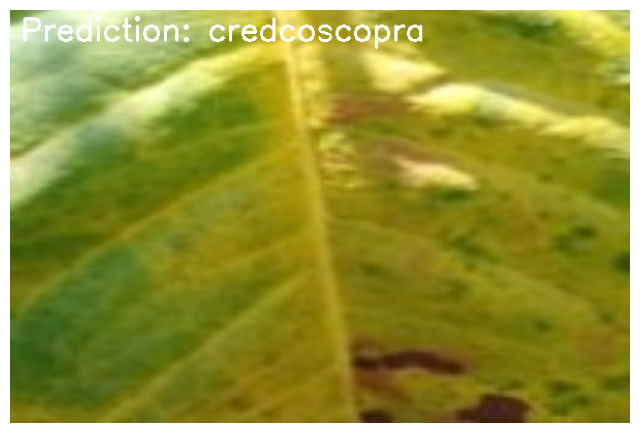

In [34]:
#call predict function to predict disease from given image
predictDisease("/content/gdrive/MyDrive/Coffee 1/testImages/10.jpg")

Resized image shape: (32, 32, 3)
Image reshaped for model: (1, 32, 32, 3)
Normalized image shape: (1, 32, 32, 3), dtype: float32
1/1 [==============================] - 0s 14ms/step
Predictions: [[1.3613519e-17 1.0000000e+00 1.2048926e-29 7.9135465e-24 8.1508391e-09]]
Prediction: healthy


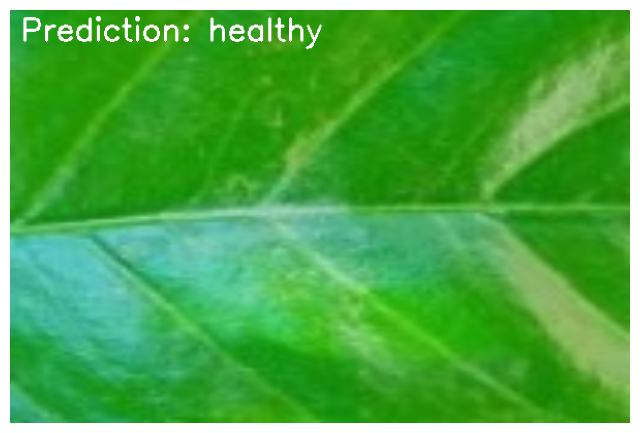

In [35]:
#call predict function to predict disease from given image
predictDisease("/content/gdrive/MyDrive/Coffee 1/testImages/2.jpg")

Resized image shape: (32, 32, 3)
Image reshaped for model: (1, 32, 32, 3)
Normalized image shape: (1, 32, 32, 3), dtype: float32
1/1 [==============================] - 0s 20ms/step
Predictions: [[1.4417141e-16 2.2135226e-32 5.5210964e-22 2.3719818e-11 1.0000000e+00]]
Prediction: phoma


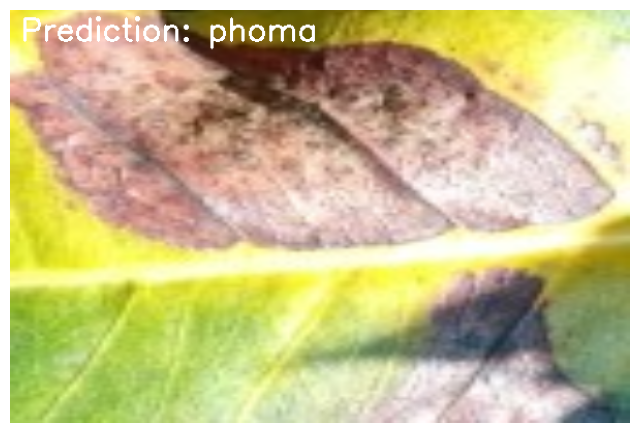

In [36]:
#call predict function to predict disease from given image
predictDisease("/content/gdrive/MyDrive/Coffee 1/testImages/4.jpg")

In [38]:
#call predict function to predict disease from given image
predictDisease("/content/gdrive/MyDrive/Coffee/testImages/9.jpg")

Error: Image not found or unable to read


In [119]:
import numpy as np

# Assuming these are your predictions
predictions = ["Benign"] * 20000000 + ["C&C"] * 40000000 + ["DDoS"] * 25000000 + ["PartOfAHorizontalPortScan"] * 100000000 + ["FileDownload"] * 2500 + ["Okiru"] * 13000000

# Assuming these are your true labels
true_labels = ["Benign"] * 25193959 + ["C&C"] * 54045940 + ["DDoS"] * 28837541 + ["PartOfAHorizontalPortScan"] * 109480720 + ["FileDownload"] * 3272 + ["Okiru"] * 13656797

# Convert labels to numeric values
labels = ["Benign", "C&C", "DDoS", "PartOfAHorizontalPortScan", "FileDownload", "Okiru"]
label_to_num = {label: i for i, label in enumerate(labels)}
predictions_numeric = [label_to_num[label] for label in predictions]
true_labels_numeric = [label_to_num[label] for label in true_labels]


In [ ]:
accuracy = np.mean(np.array(predictions_numeric) == np.array(true_labels_numeric))
print("Accuracy:", accuracy)


In [ ]:
print("Length of predictions array:", len(predictions_numeric))
print("Length of true labels array:", len(true_labels_numeric))


Length of predictions array: 198002500
Length of true labels array: 231218229


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels_numeric, predictions_numeric)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [231218229, 198002500]

In [ ]:
from sklearn.metrics import classification_report

class_report = classification_report(true_labels_numeric, predictions_numeric, target_names=labels)
print("Classification Report:\n", class_report)


In [ ]:
import pandas as pd

def read_csv_skip_rows(file_path, skip_rows=7, delimiter=';'):
    # Read the CSV file, skipping the first `skip_rows` rows and using the specified delimiter
    df = pd.read_csv(file_path, skiprows=skip_rows, delimiter=delimiter)
    return df

# Example usage
file_path = '/content/istoricultranzactiilor.csv'  # Replace with your CSV file path
dataframe = read_csv_skip_rows(file_path)


In [ ]:
dataframe.head(1)

pandas.core.frame.DataFrame

In [ ]:
onlySum=dataframe[["Suma:","Sold:"]]

In [ ]:
# onlySum.To_numeric(
numbers = pd.to_numeric(onlySum.iloc[:,0], errors='coerce')
# pd.to_numeric(onlySum.iloc[:, 0], errors='coerce').fillna(0).abs()
numbers

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
172   NaN
173   NaN
174   NaN
175   NaN
176   NaN
Name: Suma:, Length: 177, dtype: float64